# Continuous Splice Site Prediction Using Convolutional-Recurrent Networks

Okay, so let's retool a bit here. We can use recurrent NNs to do a continuous prediction...

In [3]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, \
Flatten, BatchNormalization, TimeDistributedDense
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

In [42]:
num_filters = [100,64,32]
filter_length = [6,4,6]

model1 = Sequential()
#model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
#model1.add(Dropout(0.25))
model1.add(GRU(input_dim=4, output_dim=num_filters[0], return_sequences=True))
model1.add(GRU(output_dim=num_filters[1], return_sequences=True))
model1.add(GRU(output_dim=num_filters[2], return_sequences=True))
model1.add(GRU(output_dim=1, return_sequences=True))
#model1.add(Activation('sigmoid'))

In [43]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [6]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,7:32]
Y2_train = Y_train[:,7:32]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

In [7]:
Y2_train = Y2_train.reshape((Y2_train.shape[0], Y2_train.shape[1], 1))
Y2_test = Y2_test.reshape((Y2_test.shape[0], Y2_test.shape[1], 1))

In [8]:
# intronic 5' splice sites

X2_train = X_train.map(lambda x: x[25:])
X2_test = X_test.map(lambda x: x[25:])
Y1_test = Y_test[:,50:75]
Y1_train = Y_train[:, 50:75]
X2_train = np.dstack(X2_train)
X2_train = np.rollaxis(X2_train, 2)
X2_test = np.dstack(X2_test)
X2_test = np.rollaxis(X2_test, 2)
Y1_train = Y1_train.reshape((Y1_train.shape[0], Y1_train.shape[1], 1))
Y1_test = Y1_test.reshape((Y1_test.shape[0], Y1_test.shape[1], 1))

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 339s - loss: 0.0407 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 536s - loss: 0.0240 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 358s - loss: 0.0236 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 375s - loss: 0.0234 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 339s - loss: 0.0232 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 332s - loss: 0.0185 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 346s - loss: 0.0118 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

KeyboardInterrupt: 

In [45]:
predictions = model1.predict(X1_test)

In [51]:
r2_scores = [r2_score(Y2_test[i,:,:], predictions[i,:,:]) for i in xrange(len(Y2_test))]

In [48]:
predictions.max()

0.43520492315292358

In [49]:
predictions.min()

2.30185341933975e-05

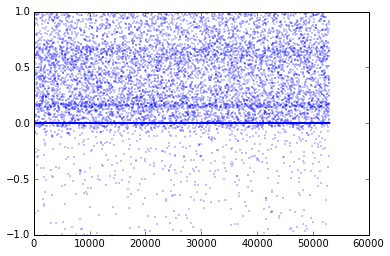

In [80]:
plt.plot(r2_scores, '.', markersize=1)
plt.ylim(-1,1)
plt.show()

In [67]:
nonneg_r2_scores = []
pos_r2_scores = []
for r in r2_scores:
    if r>=0:
        nonneg_r2_scores.append(r)
        if r>0:
            pos_r2_scores.append(r)

In [68]:
len(nonneg_r2_scores)

50016

In [69]:
len(r2_scores)

53009

In [70]:
len(pos_r2_scores)

7719

In [73]:
np.mean(nonneg_r2_scores)

0.071260946873626121

In [81]:
model1.save_weights('../data/splice-site-recurrent-1.h5')
model_json = model1.to_json()
with open('../data/splice-site-recurrent-1-model.json', 'w') as f:
    f.write(model_json)

In [83]:
# training on intronic splice data

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X2_train, Y1_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X2_test, Y1_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 342s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 345s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 3/50
 42000/212035 [====>.........................] - ETA: 263s - loss: 0.0035 - acc: 1.0000

KeyboardInterrupt: 

In [84]:
predictions = model1.predict(X1_test)

In [85]:
r2_scores = [r2_score(Y2_test[i,:,:], predictions[i,:,:]) for i in xrange(len(Y2_test))]

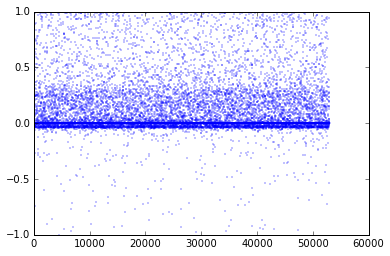

In [86]:
plt.plot(r2_scores, '.', markersize=1)
plt.ylim(-1,1)
plt.show()

In [87]:
predictions2 = model1.predict(X2_test)

In [89]:
r2_scores2 = [r2_score(Y1_test[i,:,:], predictions2[i,:,:]) for i in xrange(len(Y2_test))]

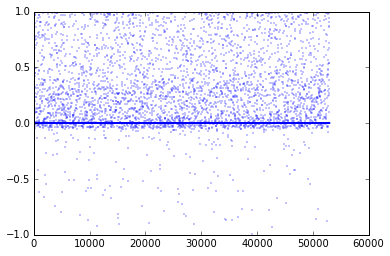

In [90]:
plt.plot(r2_scores2, '.', markersize=1)
plt.ylim(-1,1)
plt.show()

## Try 2: A Bigger Model

Also a model that uses a time-distributed dense layer as the very last layer, so that it can calculate scores compatible with the other models.

In [9]:
num_filters = [100,64,32]
filter_length = [6,4,6]

model1 = Sequential()
#model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
#model1.add(Dropout(0.25))
model1.add(GRU(input_dim=4, output_dim=num_filters[0], return_sequences=True))
model1.add(GRU(output_dim=num_filters[1], return_sequences=True))
model1.add(GRU(output_dim=num_filters[2], return_sequences=True))
model1.add(GRU(output_dim=num_filters[2], return_sequences=True))
model1.add(TimeDistributedDense(output_dim=1))
model1.add(Activation('sigmoid'))

In [10]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 380s - loss: 0.0506 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 382s - loss: 0.0241 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 381s - loss: 0.0237 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 388s - loss: 0.0234 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 421s - loss: 0.0232 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 419s - loss: 0.0232 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 426s - loss: 0.0232 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

In [12]:
predictions2 = model1.predict(X2_test)

In [13]:
r2_scores2 = [r2_score(Y1_test[i,:,:], predictions2[i,:,:]) for i in xrange(len(Y2_test))]

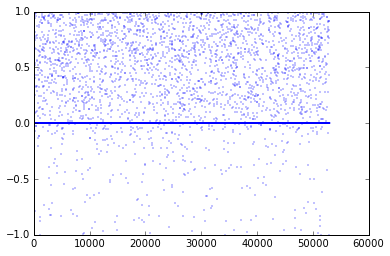

In [14]:
plt.plot(r2_scores2, '.', markersize=1)
plt.ylim(-1,1)
plt.show()

In [15]:
predictions = model1.predict(X1_test)

In [16]:
r2_scores = [r2_score(Y2_test[i,:,:], predictions[i,:,:]) for i in xrange(len(Y2_test))]

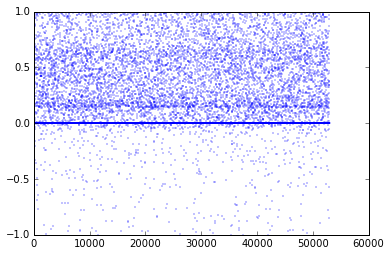

In [17]:
plt.plot(r2_scores, '.', markersize=1)
plt.ylim(-1,1)
plt.show()

In [18]:
model1.save_weights('../data/splice-site-recurrent-2.h5')
model_json = model1.to_json()
with open('../data/splice-site-recurrent-2-model.json', 'w') as f:
    f.write(model_json)

In [ ]:
s